A well known issue with Sentinel-1 frames as they are distributed is that they are not consistent in time. A fixed-size frame can move along track North or South. This makes time-series enumeration of SLCs for interferograms more complciated.

This notebook takes us through  making the Sentinel-1 "fixed-frames" (or here just "frames") derived from the burst footprints. Bursts are fixed footprints that represent imaging area of the Sentinel-1 IW-mode SAR. The burst map data has generated huge excitement because they represent fixed gegraphic areas through time. The frames that we are defining are a self-imposed organization scheme to allow us to perform large regional scale time-series analysis at roughly the scale of the originally distributed ESA frames.

The burst maps are downloaded from ESA [page](https://sar-mpc.eu/test-data-sets/). We downloaded `S1_burstid_20220530`.

There is some discussion about the metadata found in this table the next notebook. Here, we jumping right to do it to take each burst (across all three swaths) and collect them into a group of 10 within a "frame" so that each frame has a 2 burst overlap. Of course, the number of bursts within a frame and of overlapping neighboring frames could easily be re-configured here. These are based on the approximate size of frames as they are currently distributed via ESA.

In [59]:
import sqlite3
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
# from dem_stitcher.datasets import get_dem_tile_extents
from rasterio.crs import CRS
import warnings


  2%|████▋                                                                                                                                                                                            | 1137/46986 [00:20<02:37, 290.82it/s]

# Read Burst Data

The data needs to be unzipped first in this directory.

In [36]:
%%time

# SQL must wrap the geometry in hex(st_asbinary(...))
sql = "SELECT * FROM burst_id_map;"
con = sqlite3.connect("/Users/staniewi/Downloads/S1_burstid_20220530/IW/sqlite/burst_map_IW_000001_375887.sqlite3")

df_burst = gpd.GeoDataFrame.from_postgis(sql, con, geom_col="GEOMETRY", crs="EPSG:4326").rename_geometry("geometry")
con.close()

  0%|                                                                                                                                                                                                             | 0/46986 [00:44<?, ?it/s]


CPU times: user 5.76 s, sys: 237 ms, total: 5.99 s
Wall time: 6 s


In [37]:
df_burst.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [39]:
df_burst._geometry_column_name

'geometry'

# Burst Aggregation

Each burst covers three swaths. So we want to merge these bursts together as a single geometric object.

<AxesSubplot: >

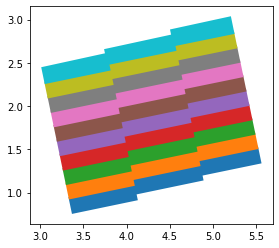

In [40]:
df_burst.head(30).plot(column='burst_id', categorical=True)

In [41]:
%%time

def join_track_numbers(orbits: list) -> str:
    orbits = list(set(orbits))
    orbits_str = list(map(str, orbits))
    return ','.join(orbits_str)


df_burst_triplet_temp = df_burst.dissolve(by='burst_id', 
                                          aggfunc={'OGC_FID': ['min', 'max'],
                                                   'relative_orbit_number': join_track_numbers,
                                                   'orbit_pass': 'first'}, 
                                          as_index=False)

/Users/staniewi/miniconda3/envs/mapping/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


CPU times: user 21.9 s, sys: 121 ms, total: 22 s
Wall time: 22 s


We keep store this as an alternative dataframe because we want to rename columns.

In [42]:
df_burst_triplet_temp.head()

,burst_id,geometry,"(OGC_FID, min)","(OGC_FID, max)","(relative_orbit_number, join_track_numbers)","(orbit_pass, first)"
0,1,"POLYGON Z ((4.12960 0.91167 0.00000, 3.76300 0...",1,3,1,ASCENDING
1,2,"POLYGON Z ((4.09471 1.07835 0.00000, 3.72810 1...",4,6,1,ASCENDING
2,3,"POLYGON Z ((4.05984 1.24503 0.00000, 3.69323 1...",7,9,1,ASCENDING
3,4,"POLYGON Z ((4.02501 1.41172 0.00000, 3.65839 1...",10,12,1,ASCENDING
4,5,"POLYGON Z ((3.99020 1.57841 0.00000, 3.62357 1...",13,15,1,ASCENDING


<AxesSubplot: >

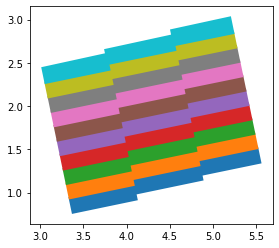

In [43]:
df_burst_triplet_temp.head(10).plot(column='burst_id', categorical=True)

In [44]:
df_burst_triplet = df_burst_triplet_temp.reset_index(drop=True)
df_burst_triplet.columns = ['burst_id', 
                            'geometry', 
                            'OGC_FID_min', 
                            'OGC_FID_max', 
                            'relative_orbit_numbers', 
                            'look_direction']
df_burst_triplet.head()

,burst_id,geometry,OGC_FID_min,OGC_FID_max,relative_orbit_numbers,look_direction
0,1,"POLYGON Z ((4.12960 0.91167 0.00000, 3.76300 0...",1,3,1,ASCENDING
1,2,"POLYGON Z ((4.09471 1.07835 0.00000, 3.72810 1...",4,6,1,ASCENDING
2,3,"POLYGON Z ((4.05984 1.24503 0.00000, 3.69323 1...",7,9,1,ASCENDING
3,4,"POLYGON Z ((4.02501 1.41172 0.00000, 3.65839 1...",10,12,1,ASCENDING
4,5,"POLYGON Z ((3.99020 1.57841 0.00000, 3.62357 1...",13,15,1,ASCENDING


# Frame size analysis

In [670]:
def make_frame_slices(num_bursts, n_bursts_per_frame=12, overlap=1):
    N = int(np.ceil(num_bursts / (n_bursts_per_frame - overlap)))
    starts = [k * (n_bursts_per_frame - overlap) for k in range(N)]
    return [slice(start, start + n_bursts_per_frame) for start in starts]

In [673]:
make_frame_slices(45, 12, 1)

[slice(0, 12, None),
 slice(11, 23, None),
 slice(22, 34, None),
 slice(33, 45, None),
 slice(44, 56, None)]

In [674]:
df_burst_count_per_track = df_burst[['relative_orbit_number', 'burst_id']].groupby('relative_orbit_number').burst_id.nunique()
burst_count_per_track = df_burst_count_per_track.to_dict()

In [677]:
from collections import Counter

results = []
for n_bursts_per_frame in [9, 10, 11, 12, 13]:
    for overlap in [1, 2]:
        track_to_slices = {}
        for track, count in burst_count_per_track.items():
            b = np.arange(count)
            slices = make_frame_slices(count, n_bursts_per_frame=n_bursts_per_frame, overlap=overlap)
            track_to_slices[track] = len(b[slices[-1]])
        print(f"{n_bursts_per_frame} bursts / frame, {overlap} overlap")
        print(f"final frame sizes: {Counter(track_to_slices.values())}")
        print("-"*20)
        for (leftover, count) in Counter(track_to_slices.values()).items():
            results.append((n_bursts_per_frame, overlap, leftover, count))

9 bursts / frame, 1 overlap
final frame sizes: Counter({4: 162, 3: 13})
--------------------
9 bursts / frame, 2 overlap
final frame sizes: Counter({6: 162, 5: 13})
--------------------
10 bursts / frame, 1 overlap
final frame sizes: Counter({6: 162, 5: 13})
--------------------
10 bursts / frame, 2 overlap
final frame sizes: Counter({4: 162, 3: 13})
--------------------
11 bursts / frame, 1 overlap
final frame sizes: Counter({8: 162, 7: 13})
--------------------
11 bursts / frame, 2 overlap
final frame sizes: Counter({6: 162, 5: 13})
--------------------
12 bursts / frame, 1 overlap
final frame sizes: Counter({3: 162, 2: 13})
--------------------
12 bursts / frame, 2 overlap
final frame sizes: Counter({8: 162, 7: 13})
--------------------
13 bursts / frame, 1 overlap
final frame sizes: Counter({12: 162, 11: 13})
--------------------
13 bursts / frame, 2 overlap
final frame sizes: Counter({3: 162, 2: 13})
--------------------


In [678]:
pd.DataFrame(results, columns=['n_bursts_per_frame', 'overlap', 'leftover', 'count'])

,n_bursts_per_frame,overlap,leftover,count
0,9,1,4,162
1,9,1,3,13
2,9,2,6,162
3,9,2,5,13
4,10,1,6,162
5,10,1,5,13
6,10,2,4,162
7,10,2,3,13
8,11,1,8,162
9,11,1,7,13


## Thoughts on frame size

**11 bursts per frame, 1 overlap only has leftovers of 7 and 8 bursts**

This seems not so bad- final frame isn't much smaller than the rest

13 bursts per frame with 1 overlap does alright. But 13 bursts long is about 280-290 km... which is a very big frame.

In [679]:
%%time
n_bursts_per_frame = 11
overlap = 1

df_burst_count_per_track = df_burst[['relative_orbit_number', 'burst_id']].groupby('relative_orbit_number').burst_id.nunique()
burst_count_per_track = df_burst_count_per_track.to_dict()

# frame_to_ogc_fid = {}  # would need to multiplt slice idxs by 3
frame_to_burst_id = []

track_to_slices = {}
for track, count in burst_count_per_track.items():
    current_burst_ids = df_burst[df_burst.relative_orbit_number == track].burst_id.unique()
    slices = make_frame_slices(count, n_bursts_per_frame=n_bursts_per_frame, overlap=overlap)
    
    for frame_num, cur_slice in enumerate(slices, start=1):
        for b_id in current_burst_ids[cur_slice]:
            frame_to_burst_id.append((track, frame_num, b_id))

            
df_frame_to_burst_id = pd.DataFrame(frame_to_burst_id, columns=["relative_orbit_number", "frame_number", "burst_id"])
df_frame_to_burst_id

CPU times: user 499 ms, sys: 19.8 ms, total: 519 ms
Wall time: 526 ms


,relative_orbit_number,frame_number,burst_id
0,1,1,1
1,1,1,2
2,1,1,3
3,1,1,4
4,1,1,5
...,...,...,...
413332,175,215,375883
413333,175,215,375884
413334,175,215,375885
413335,175,215,375886


In [695]:
df_burst.head().to_file("testblah.gpkg")

In [696]:
!sqlite3 testblah.gpkg .tables

-- Loading resources from /Users/staniewi/.sqliterc
load_extension('mod_spatialite')
--------------------------------
                                
Run Time: real 0.023 user 0.010324 sys 0.007401
gpkg_contents               gpkg_tile_matrix_set      
gpkg_extensions             rtree_testblah_geom       
gpkg_geometry_columns       rtree_testblah_geom_node  
gpkg_ogr_contents           rtree_testblah_geom_parent
gpkg_spatial_ref_sys        rtree_testblah_geom_rowid 
gpkg_tile_matrix            testblah                  


In [681]:
with sqlite3.connect("test/esa_burst_db.gpkg") as con:
    df_frame_to_burst_id.to_sql("frames_bursts", con)
    con.execute("CREATE INDEX IF NOT EXISTS idx_burst_id_map_burst_id ON burst_id_map (burst_id)")
    con.execute("CREATE INDEX IF NOT EXISTS idx_frames_bursts_burst_id ON frames_bursts (burst_id)")
    con.execute("CREATE INDEX IF NOT EXISTS idx_frames_bursts_tracK_frame ON frames_bursts (relative_orbit_number, frame_number)")

In [687]:
df_frame_to_burst_id

,relative_orbit_number,frame_number,burst_id
0,1,1,1
1,1,1,2
2,1,1,3
3,1,1,4
4,1,1,5
...,...,...,...
413332,175,215,375883
413333,175,215,375884
413334,175,215,375885
413335,175,215,375886


In [647]:
# df_frame_to_burst_id.groupby(["relative_orbit_number", "frame_number"], as_index=False).count().burst_id.unique()
# # df_frame_to_burst_id[df_frame_to_burst_id.relative_orbit_number == 1]

In [686]:
print(f"{len(df_frame_to_burst_id.groupby(['relative_orbit_number', 'frame_number']))} total frames")

37625 total frames


In [45]:
n_bursts = 10
o_bursts = 2
M = df_burst_triplet.burst_id.max()
N = int(np.ceil(M / (n_bursts - o_bursts)))

starts = [k * (n_bursts - o_bursts) for k in range(N)]

In [46]:
slices = [df_burst_triplet.iloc[start: start+ n_bursts] for start in tqdm(starts)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46986/46986 [00:10<00:00, 4305.04it/s]


In [47]:
def join_look_direction(look_direction_l: list) -> str:
    return ','.join(list(set(look_direction_l)))

The `aggfunc` does make this slower geometry dissolve slower. We filter out future warnings as well as this needs to be resolved in the `geopandas` library.

In [51]:
import shapely
shapely.__version__

'2.0.0'

In [60]:
%%time

agg_dict = {'OGC_FID_min': 'min',
            'OGC_FID_max': 'max',
            'burst_id': ['min', 'max'],
            'relative_orbit_numbers': join_track_numbers,
            'look_direction': join_look_direction}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=(FutureWarning, RuntimeWarning))
    frames_l = [df_s.dissolve(aggfunc=agg_dict) for df_s in tqdm(slices)]

  0%|          | 0/46986 [00:00<?, ?it/s]

  5%|█████████▌                                                                                                                                                                                        | 2326/46986 [03:03<58:37, 12.70it/s]


CPU times: user 2min 31s, sys: 1.23 s, total: 2min 32s
Wall time: 2min 32s


In [61]:
df_frames_temp = pd.concat(frames_l, axis=0)
df_frames_temp.head()

,geometry,"(OGC_FID_min, min)","(OGC_FID_max, max)","(burst_id, min)","(burst_id, max)","(relative_orbit_numbers, join_track_numbers)","(look_direction, join_look_direction)"
0,"POLYGON Z ((3.33269 0.92005 0.00000, 3.33269 0...",1,30,1,10,1,ASCENDING
0,"POLYGON Z ((3.05247 2.25444 0.00000, 3.05247 2...",25,54,9,18,1,ASCENDING
0,"POLYGON Z ((2.77387 3.58901 0.00000, 2.77363 3...",49,78,17,26,1,ASCENDING
0,"POLYGON Z ((2.49742 4.92387 0.00000, 2.49611 4...",73,102,25,34,1,ASCENDING
0,"POLYGON Z ((2.22069 6.25855 0.00000, 2.22069 6...",97,126,33,42,1,ASCENDING


Format the frames.

In [62]:
df_frames = df_frames_temp.reset_index(drop=True)
df_frames.columns = ['geometry', 
                     'OGC_FID_min', 
                     'OGC_FID_max', 
                     'burst_id_min', 
                     'burst_id_max', 
                     'relative_orbit_numbers',
                     'look_direction']
# reorder columns
df_frames = df_frames[[col for col in df_frames.columns if col != 'geometry'] + ['geometry']]
df_frames.head()

,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,1,30,1,10,1,ASCENDING,"POLYGON Z ((3.33269 0.92005 0.00000, 3.33269 0..."
1,25,54,9,18,1,ASCENDING,"POLYGON Z ((3.05247 2.25444 0.00000, 3.05247 2..."
2,49,78,17,26,1,ASCENDING,"POLYGON Z ((2.77387 3.58901 0.00000, 2.77363 3..."
3,73,102,25,34,1,ASCENDING,"POLYGON Z ((2.49742 4.92387 0.00000, 2.49611 4..."
4,97,126,33,42,1,ASCENDING,"POLYGON Z ((2.22069 6.25855 0.00000, 2.22069 6..."


In [ ]:
# df_frames_temp.head().plot(column=)

In [66]:
df_frames.iloc[:5]

,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,1,30,1,10,1,ASCENDING,"POLYGON Z ((3.33269 0.92005 0.00000, 3.33269 0..."
1,25,54,9,18,1,ASCENDING,"POLYGON Z ((3.05247 2.25444 0.00000, 3.05247 2..."
2,49,78,17,26,1,ASCENDING,"POLYGON Z ((2.77387 3.58901 0.00000, 2.77363 3..."
3,73,102,25,34,1,ASCENDING,"POLYGON Z ((2.49742 4.92387 0.00000, 2.49611 4..."
4,97,126,33,42,1,ASCENDING,"POLYGON Z ((2.22069 6.25855 0.00000, 2.22069 6..."


<AxesSubplot: >

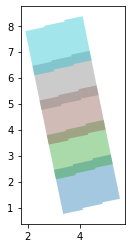

In [73]:
# df_frames.iloc[:5].boundary.plot() # column='burst_id', categorical=True)
df_frames.iloc[:5].plot(column='burst_id_min', categorical=True, alpha=.4)

# Land Intersection

We are going to read a 1 degree buffered land area. This should encompass all land areas relevant for the product. We use this same mask (at full resolution) for the browse imagery.

In [74]:
df_land = gpd.read_file('usgs_land_1deg_buffered.geojson')    
land_geo = df_land.geometry.unary_union

In [75]:
%%time

ind_land = df_frames.geometry.intersects(land_geo)

CPU times: user 3min 26s, sys: 6.49 s, total: 3min 32s
Wall time: 11min 5s


/Users/staniewi/miniconda3/envs/mapping/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [76]:
df_frames_land = df_frames[ind_land].reset_index(drop=True)
df_frames_land.head()

,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,25,54,9,18,1,ASCENDING,"POLYGON Z ((3.05247 2.25444 0.00000, 3.05247 2..."
1,49,78,17,26,1,ASCENDING,"POLYGON Z ((2.77387 3.58901 0.00000, 2.77363 3..."
2,73,102,25,34,1,ASCENDING,"POLYGON Z ((2.49742 4.92387 0.00000, 2.49611 4..."
3,97,126,33,42,1,ASCENDING,"POLYGON Z ((2.22069 6.25855 0.00000, 2.22069 6..."
4,121,150,41,50,1,ASCENDING,"POLYGON Z ((1.94483 7.59326 0.00000, 1.94483 7..."


Now that we have the total frames - we are going to assign frame ids.

In [77]:
df_frames_land = df_frames_land.reset_index(drop=False)
df_frames_land.rename(columns={'index': 'frame_id'}, inplace=True)
df_frames_land.loc[:, "frame_id"] += 1

# Dateline Fix

We take the multipolygons at the dateline and make sure we have geometries at the left and right hemispheres. This will mean we don't have to take care of this during enumeration of IFGs.

In [80]:
buffer = 5

In [81]:
df_dateline = df_frames_land.cx[:-180 + buffer,:]
df_dateline.head()

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
60,60,1897,1926,633,642,1,DESCENDING,"POLYGON Z ((-175.13922 71.94575 0.00000, -175...."
61,61,1921,1950,641,650,1,DESCENDING,"MULTIPOLYGON Z (((-176.24122 70.60947 0.00000,..."
62,62,1945,1974,649,658,1,DESCENDING,"MULTIPOLYGON Z (((-177.19180 69.31480 0.00000,..."
63,63,1969,1998,657,666,1,DESCENDING,"MULTIPOLYGON Z (((-178.05114 68.01650 0.00000,..."
64,64,1993,2022,665,674,1,DESCENDING,"MULTIPOLYGON Z (((-178.83437 66.71513 0.00000,..."


In [82]:
multipolygon_index = df_dateline.geometry.map(lambda geo: (geo.geom_type != 'Polygon'))
df_dateline_multi = df_dateline[multipolygon_index].copy()

These plots show how the frames at the dateline are concatentated. There "missing" portion is in the right hemisphere.

In [357]:
def antimeridian_epsg(mp):
    y_c = mp.centroid.y
    # check north/south pole cases
    if y_c >= 84.0:
        return 3413
    elif y_c <= -60.0:
        return 3031

    # otherwise, do the weighted average of the shifted polygons to get the centroid
    A = 0 
    x_weighted = 0
    # might have 2 or 3 polygons
    for g in mp.geoms:
        A += g.area
        if g.centroid.x < 0:
            g_shifted = translate(g, xoff=360)
            x_weighted += g_shifted.centroid.x * g.area
        else:
            x_weighted += g.centroid.x * g.area
    x_c = x_weighted / A
    print(x_c)

    base = 32600 if y_c > 0 else 32700
    # longitude 179 gets 32660 north of the equator
    # longitude -179 gets 32601
    zone_addition = 1 if x_c < 180 else 60
    return base + zone_addition

In [428]:
# %%time

# https://github.com/Turbo87/utm
import utm

epsgs = np.zeros(len(df_frames_land), dtype=int)

# do the antimeridian frames first
am_idxs = df_frames_land.geometry.map(lambda geo: (geo.geom_type != 'Polygon')).values
epsgs[am_idxs] = df_frames_land[am_idxs].geometry.map(antimeridian_epsg)

# everything else
# get the x, y (lon, lat) coords of all other rows
other_coords = np.array(df_frames_land[~am_idxs].geometry.map(lambda g: tuple(g.centroid.coords)[0]).tolist())
xs, ys = other_coords.T
ys_full_size = np.ones(len(epsgs)) * np.nan
ys_full_size[~am_idxs] = ys

idxs = np.logical_and.reduce((~am_idxs, ys_full_size > 84))
epsgs[idxs] = 3413

idxs = np.logical_and.reduce((~am_idxs, ys_full_size < -60))
epsgs[idxs] = 3031

utm_idxs = np.logical_and(ys < 84, ys > -60)
north_idxs = ys[utm_idxs] > 0


# North hemisphere

zones_north = [utm.from_latlon(y, x)[2] for (y, x) in zip(ys[utm_idxs][north_idxs], xs[utm_idxs][north_idxs])]
idxs = np.logical_and.reduce((~am_idxs, ys_full_size < 84, ys_full_size > 0))
epsgs[idxs] = 32600 + np.array(zones_north)

# South hemisphere

zones_south = [utm.from_latlon(y, x)[2] for (y, x) in zip(ys[utm_idxs][~north_idxs], xs[utm_idxs][~north_idxs])]
idxs = np.logical_and.reduce((~am_idxs, ys_full_size > -60, ys_full_size < 0))
epsgs[idxs] = 32700 + np.array(zones_south)

In [435]:
df_frames_land.shape, epsgs.shape

((24359, 8), (24359,))

In [432]:
df_frames_land.head()

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,0,25,54,9,18,1,ASCENDING,"POLYGON Z ((3.05247 2.25444 0.00000, 3.05247 2..."
1,1,49,78,17,26,1,ASCENDING,"POLYGON Z ((2.77387 3.58901 0.00000, 2.77363 3..."
2,2,73,102,25,34,1,ASCENDING,"POLYGON Z ((2.49742 4.92387 0.00000, 2.49611 4..."
3,3,97,126,33,42,1,ASCENDING,"POLYGON Z ((2.22069 6.25855 0.00000, 2.22069 6..."
4,4,121,150,41,50,1,ASCENDING,"POLYGON Z ((1.94483 7.59326 0.00000, 1.94483 7..."


In [322]:
# %%time
# df_frames_land.geometry.map(get_polygon_epsg)

In [294]:
# dd = df_dateline[multipolygon_index].copy()
# am_centroids = dd.geometry.map(lambda geo: (geo.geoms[0].centroid.x, geo.geoms[1].centroid.x))
# dd[am_centroids.map(lambda tup: tup[0] > tup[1])]

In [504]:
df_burst.iloc[:10].set_index("OGC_FID")

,geometry,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass
OGC_FID,,,,,,
1,"MULTIPOLYGON Z (((3.36758 0.75322 0.00000, 3.7...",1,IW1,1,2.301015,ASCENDING
2,"MULTIPOLYGON Z (((4.09178 0.97402 0.00000, 4.5...",1,IW2,1,3.133218,ASCENDING
3,"MULTIPOLYGON Z (((4.85545 1.19200 0.00000, 5.2...",1,IW3,1,4.211255,ASCENDING
4,"MULTIPOLYGON Z (((3.33269 0.92005 0.00000, 3.7...",2,IW1,1,5.059288,ASCENDING
5,"MULTIPOLYGON Z (((4.05690 1.14071 0.00000, 4.4...",2,IW2,1,5.891491,ASCENDING
6,"MULTIPOLYGON Z (((4.82062 1.35851 0.00000, 5.1...",2,IW3,1,6.969528,ASCENDING
7,"MULTIPOLYGON Z (((3.29783 1.08689 0.00000, 3.6...",3,IW1,1,7.817561,ASCENDING
8,"MULTIPOLYGON Z (((4.02205 1.30740 0.00000, 4.4...",3,IW2,1,8.649764,ASCENDING
9,"MULTIPOLYGON Z (((4.78582 1.52502 0.00000, 5.1...",3,IW3,1,9.727801,ASCENDING


In [506]:
!rm test1.gpkg
df_burst.iloc[:10].set_index("OGC_FID").to_file("test1.gpkg", driver="GPKG", index=False)

/Users/staniewi/Documents/Learning/notebooks


(-90.0, 90.0)

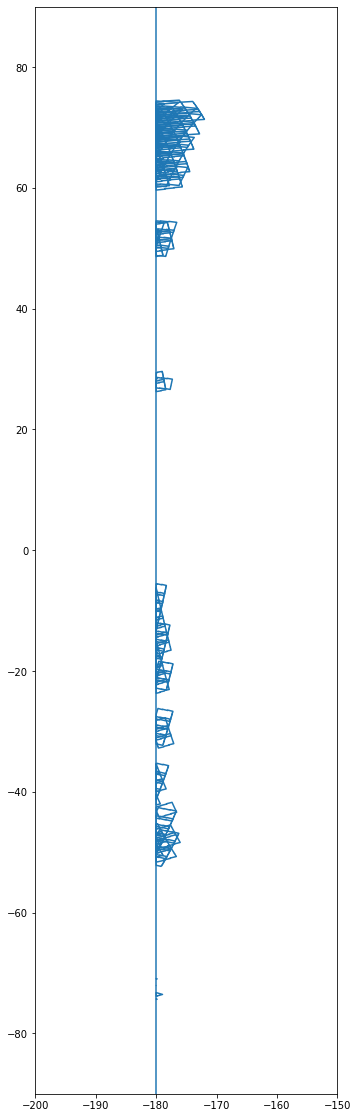

In [87]:
fig, ax = plt.subplots(figsize=(10, 20))
ax.vlines(-180, -90, 90)
df_dateline_multi.boundary.plot(ax=ax)
ax.set_xlim(-200, -150)
ax.set_ylim(-90, 90)

In [88]:
df_dateline_l = df_dateline_multi.copy()
df_dateline_r = df_dateline_multi.copy()

# The buffer ensures there is some overlap for merging by frame id
geo_l = df_dateline_multi.translate(xoff=-360).buffer(1e-7)
df_dateline_l.geometry = df_dateline_multi.geometry.union(geo_l)
df_dateline_l_f = df_dateline_l.dissolve(by='frame_id', aggfunc='first').explode(index_parts=False)
# only want the areas that are at the left hemisphere dateline
df_dateline_l_f = df_dateline_l_f.cx[-180- 80:-180 + buffer, :].reset_index(drop=False)

geo_r = df_dateline_multi.translate(xoff=360).buffer(1e-7)
df_dateline_r.geometry = df_dateline_multi.geometry.union(geo_r)
df_dateline_r_f = df_dateline_r.dissolve(by='frame_id', aggfunc='first').explode(index_parts=False)
# only want the areas that are at the right hemisphere dateline
df_dateline_r_f = df_dateline_r_f.cx[180 - buffer: 180 + 80, :].reset_index(drop=False)

/var/folders/hw/sj9hl8555s36n00t812twvcr0000gq/T/ipykernel_89525/1531954237.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_l = df_dateline_multi.translate(xoff=-360).buffer(1e-7)
/Users/staniewi/miniconda3/envs/mapping/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/staniewi/miniconda3/envs/mapping/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/var/folders/hw/sj9hl8555s36n00t812twvcr0000gq/T/ipykernel_89525/1531954237.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_r = df_dateline_multi.translate(xoff=360).bu

In [89]:
df_dateline_l_f.head()

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,61,1921,1950,641,650,1,DESCENDING,"POLYGON Z ((-178.60410 70.72891 0.00000, -179...."
1,62,1945,1974,649,658,1,DESCENDING,"POLYGON Z ((-179.41537 69.42670 0.00000, -180...."
2,63,1969,1998,657,666,1,DESCENDING,"POLYGON Z ((-180.00000 68.17156 0.00000, -180...."
3,64,1993,2022,665,674,1,DESCENDING,"POLYGON Z ((-180.00000 66.81243 0.00000, -180...."
4,65,2017,2046,673,682,1,DESCENDING,"POLYGON Z ((-180.00000 65.44949 0.00000, -180...."


These few plots summarize our geometric manipulations showing the how we merged at each hemisphere.

(-70.0, 50.0)

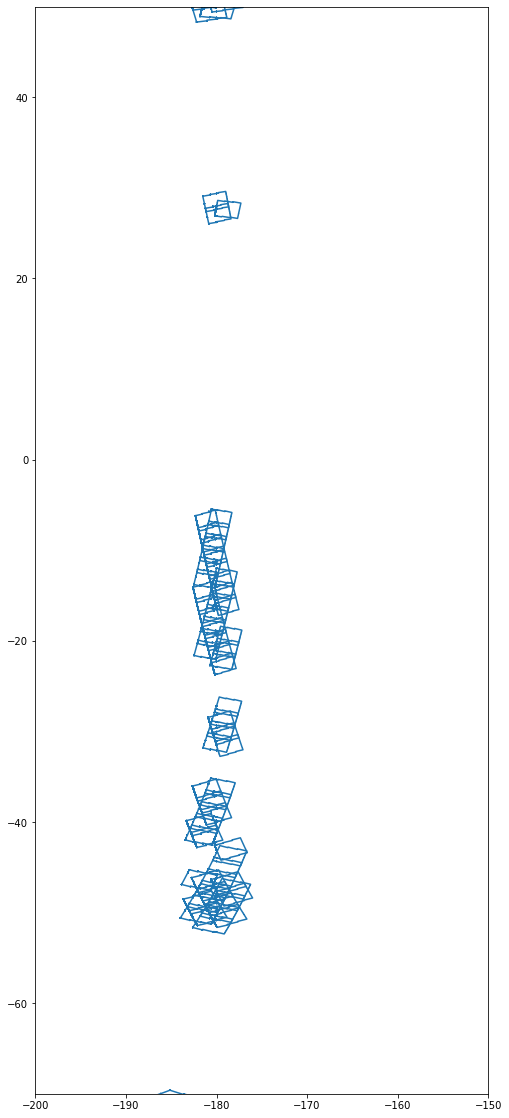

In [90]:
fig, ax = plt.subplots(figsize=(10, 20))

df_dateline_l_f.boundary.plot(ax = ax)
ax.set_xlim(-200, -150)
ax.set_ylim(-70, 50)

(-70.0, 50.0)

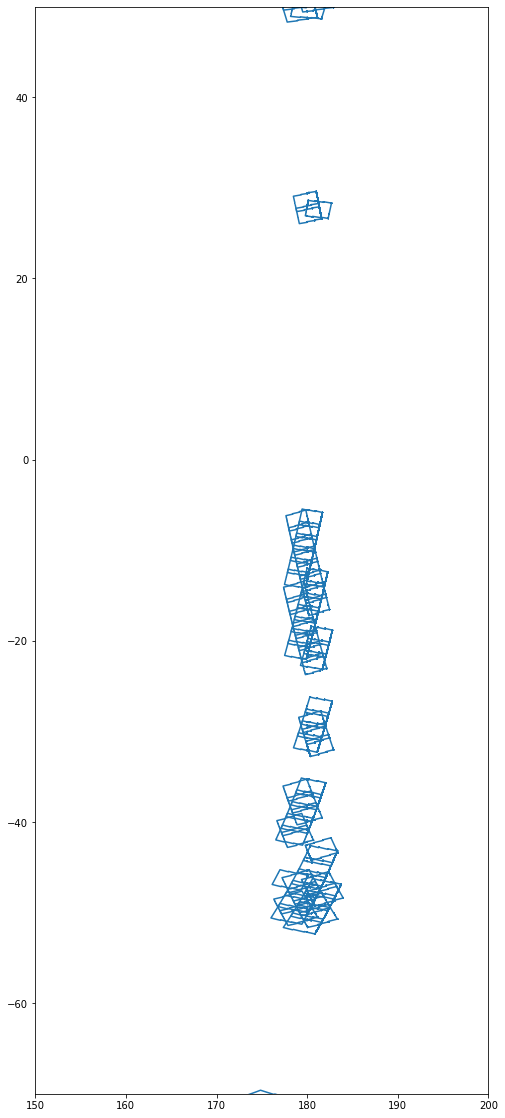

In [91]:
fig, ax = plt.subplots(figsize=(10, 20))

df_dateline_r_f.boundary.plot(ax = ax)
ax.set_xlim(150, 200)
ax.set_ylim(-70, 50)

In [95]:
# df_dateline_l_f.frame_id.tolist()
# df_dateline_r_f.frame_id.tolist()

In [96]:
frame_ids_l = df_dateline_l_f.frame_id.tolist()
frame_ids_r = df_dateline_r_f.frame_id.tolist()
frame_ids_dateline = list(set(frame_ids_l + frame_ids_r))

In [97]:
dateline_ind = df_frames_land.frame_id.isin(frame_ids_dateline)
df_dateline_removed = df_frames_land[~dateline_ind].copy()
dfs = [df_dateline_removed, df_dateline_r_f, df_dateline_l_f]
df_frames_final = pd.concat(dfs, axis=0).reset_index(drop=True)
df_frames_final.head()

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,0,25,54,9,18,1,ASCENDING,"POLYGON Z ((3.05247 2.25444 0.00000, 3.05247 2..."
1,1,49,78,17,26,1,ASCENDING,"POLYGON Z ((2.77387 3.58901 0.00000, 2.77363 3..."
2,2,73,102,25,34,1,ASCENDING,"POLYGON Z ((2.49742 4.92387 0.00000, 2.49611 4..."
3,3,97,126,33,42,1,ASCENDING,"POLYGON Z ((2.22069 6.25855 0.00000, 2.22069 6..."
4,4,121,150,41,50,1,ASCENDING,"POLYGON Z ((1.94483 7.59326 0.00000, 1.94483 7..."


In [227]:
df_frames_final[21610 == df_frames_final.frame_id]

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
21646,21610,1125091,1125120,375031,375040,175,DESCENDING,"POLYGON Z ((178.97555 -37.11883 0.00000, 178.5..."
21787,21610,1125091,1125120,375031,375040,175,DESCENDING,"POLYGON Z ((-180.00000 -35.68179 0.00000, -180..."


In [195]:
1125039 - 1125010, 1125120 - 1125091

(29, 29)

In [193]:
df_frames_final.tail()

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
21783,21606,1124929,1124958,374977,374986,175,DESCENDING,"POLYGON Z ((-178.15174 -28.25211 0.00000, -178..."
21784,21607,1124956,1124985,374986,374995,175,DESCENDING,"POLYGON Z ((-178.98142 -29.64642 0.00000, -178..."
21785,21608,1124983,1125012,374995,375004,175,DESCENDING,"POLYGON Z ((-179.44244 -31.12599 0.00000, -179..."
21786,21609,1125010,1125039,375004,375013,175,DESCENDING,"POLYGON Z ((-179.91796 -32.60357 0.00000, -179..."
21787,21610,1125091,1125120,375031,375040,175,DESCENDING,"POLYGON Z ((-180.00000 -35.68179 0.00000, -180..."


# Serialization

Uncomment to inspect.

In [98]:
df_frames_final.to_file('s1-frames.geojson', driver='GeoJSON')
df_frames_final.to_file('s1-frames.gpkg', driver='GPKG')

In [148]:
df_frames_final = gpd.read_file("s1-frames-10frames-1overlap.gpkg")
df_frames_final

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,1,28,57,10,19,1,ASCENDING,"POLYGON Z ((3.01777 2.42129 0.00000, 3.01776 2..."
1,2,55,84,19,28,1,ASCENDING,"POLYGON Z ((2.70450 3.92269 0.00000, 2.70450 3..."
2,3,82,111,28,37,1,ASCENDING,"POLYGON Z ((2.39275 5.42421 0.00000, 2.39275 5..."
3,4,109,138,37,46,1,ASCENDING,"POLYGON Z ((2.08218 6.92580 0.00000, 2.08218 6..."
4,5,136,165,46,55,1,ASCENDING,"POLYGON Z ((1.77252 8.42742 0.00000, 1.77252 8..."
...,...,...,...,...,...,...,...,...
21783,21606,1124929,1124958,374977,374986,175,DESCENDING,"POLYGON Z ((-178.15174 -28.25211 0.00000, -178..."
21784,21607,1124956,1124985,374986,374995,175,DESCENDING,"POLYGON Z ((-178.98142 -29.64642 0.00000, -178..."
21785,21608,1124983,1125012,374995,375004,175,DESCENDING,"POLYGON Z ((-179.44244 -31.12599 0.00000, -179..."
21786,21609,1125010,1125039,375004,375013,175,DESCENDING,"POLYGON Z ((-179.91796 -32.60357 0.00000, -179..."


In [156]:
df_frames_final.head(12)

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,1,28,57,10,19,1,ASCENDING,"POLYGON Z ((3.01777 2.42129 0.00000, 3.01776 2..."
1,2,55,84,19,28,1,ASCENDING,"POLYGON Z ((2.70450 3.92269 0.00000, 2.70450 3..."
2,3,82,111,28,37,1,ASCENDING,"POLYGON Z ((2.39275 5.42421 0.00000, 2.39275 5..."
3,4,109,138,37,46,1,ASCENDING,"POLYGON Z ((2.08218 6.92580 0.00000, 2.08218 6..."
4,5,136,165,46,55,1,ASCENDING,"POLYGON Z ((1.77252 8.42742 0.00000, 1.77252 8..."
5,6,163,192,55,64,1,ASCENDING,"POLYGON Z ((1.45775 9.95702 0.00000, 1.45775 9..."
6,7,190,219,64,73,1,ASCENDING,"POLYGON Z ((1.15354 11.43695 0.00000, 1.11985 ..."
7,8,217,246,73,82,1,ASCENDING,"POLYGON Z ((0.84367 12.94446 0.00000, 0.80707 ..."
8,9,244,273,82,91,1,ASCENDING,"POLYGON Z ((0.53634 14.43758 0.00000, 0.50271 ..."
9,10,271,300,91,100,1,ASCENDING,"POLYGON Z ((0.22495 15.94760 0.00000, 0.19036 ..."


# Normalize data to row format

In [160]:
frame_ogc_ids = []
for frame_id, id_min, id_max in df_frames_final[['frame_id', 'OGC_FID_min', "OGC_FID_max"]].values:
    for i in range(id_min, id_max + 1):
        frame_ogc_ids.append((frame_id, i))

        
df_frame_normalized = pd.DataFrame(frame_ogc_ids, columns=("frame_id", "OGC_FID"))
df_frame_normalized[27:35]

,frame_id,OGC_FID
27,1,55
28,1,56
29,1,57
30,2,55
31,2,56
32,2,57
33,2,58
34,2,59


In [161]:
!cp /Users/staniewi/repos/burst_db/burst_map.sqlite3 /Users/staniewi/repos/burst_db/burst_map_with_frames.sqlite3

In [173]:
df_frames_final.dtypes

frame_id                     int64
OGC_FID_min                  int64
OGC_FID_max                  int64
burst_id_min                 int64
burst_id_max                 int64
relative_orbit_numbers      object
look_direction              object
geometry                  geometry
dtype: object

In [179]:
df_frames_final[['frame_id', 'look_direction']].groupby("look_direction").count()

,frame_id
look_direction,
ASCENDING,10809
"ASCENDING,DESCENDING",166
DESCENDING,10813


In [180]:
df_frames_final[['frame_id', 'relative_orbit_numbers']].groupby("relative_orbit_numbers").count()

,frame_id
relative_orbit_numbers,
1,126
10,147
"10,11",1
100,134
101,116
...,...
"97,96",1
"97,98",1
98,144


## Save as a table within existing burst DB

In [ ]:
df_frames_land.loc[:, "epsg"] = epsgs

In [441]:
!ls

0 Prepare USGS Data.ipynb
1 Generate Frames from S1-bursts.ipynb
2 Discussion.ipynb
bootstrapping for variance in a timeseries.ipynb
coherence simulations.ipynb
data
dataframe_temp.gpkg
double descent.ipynb
nmap analysis.ipynb
s1-frames-10frames-1overlap.geojson
s1-frames-10frames-1overlap.gpkg
s1-frames-10frames-2overlap.geojson
s1-frames-10frames-2overlap.geojson.zip
s1-frames-10frames-2overlap.gpkg
s1-frames-11frames-1overlap.geojson
s1-frames-11frames-1overlap.gpkg
s1-frames-11frames-2overlap.geojson
s1-frames-11frames-2overlap.gpkg
test
test.sqlite3
test1.sqlite3
usgs_land_1deg_buffered.geojson


In [442]:
df_frames_land.loc[:, ["frame_id", "epsg", "geometry"]].to_file("test/frames.gpkg", driver="GPKG")

In [162]:
table_name = "frames"
con = sqlite3.connect("/Users/staniewi/repos/burst_db/burst_map_with_frames.sqlite3")

df_frame_normalized.to_sql(table_name, con=con, index=False)
con.execute("CREATE INDEX idx_frames_frame_id ON frames (frame_id)")
con.execute("CREATE INDEX idx_frames_OGC_FID ON frames (OGC_FID)")
con.close

<function Connection.close()>

In [443]:
df_frame_normalized.head()

,frame_id,OGC_FID
0,1,28
1,1,29
2,1,30
3,1,31
4,1,32


,frame_id,OGC_FID
0,1,28
1,1,29
2,1,30
3,1,31
4,1,32
...,...,...
653635,21610,1125116
653636,21610,1125117
653637,21610,1125118
653638,21610,1125119


In [459]:
df_burst.iloc[-1000:].shape

(1000, 7)

In [457]:
df_frames_land.geometry[df_frames_land.geometry.map(lambda geo: (geo.geom_type != "Polygon"))].apply(lambda g: len(g.geoms)).unique()

array([2])

In [460]:
from shapely import wkt
gbad = wkt.loads('MULTIPOLYGON Z (((-178.8827675124469 29.06025377982273 0, -178.850261 28.894183 0, -179.247383 28.836209 0, -179.63423701583096 28.778422756438413 0, -179.622798 28.722182 0, -180 28.664259480878457 0, -180 28.83577230606064 0, -180 28.85959691321272 0, -180 29.00725903541127 0, -180 29.031418385392033 0, -180 29.17871778491337 0, -180 29.203211181979714 0, -180 29.35014879205192 0, -180 29.374976101771388 0, -180 29.521553149134178 0, -180 29.546713182664217 0, -180 29.69292894835176 0, -180 29.71842114176748 0, -180 29.864276449387464 0, -180 29.890101230138367 0, -180 30.035597526808452 0, -180 30.061750865669413 0, -180 30.20689126898366 0, -180 30.233374178296952 0, -180 30.40496886361689 0, -179.99144771004862 30.406331440405676 0, -180 30.44799120244946 0, -180 30.46669508368907 0, -179.585111 30.531726 0, -179.181945 30.593659 0, -179.14928991478934 30.427634550984223 0, -179.149287 30.427635 0, -179.14452619101806 30.40341490466317 0, -179.141664 30.388863 0, -179.14166575522586 30.38886275021734 0, -179.11665114764273 30.2616036682467 0, -179.116649 30.261604 0, -179.11260209304214 30.241004545529766 0, -179.109031 30.222837 0, -179.10903289838532 30.222836729072945 0, -179.076415 30.056806 0, -179.07812223716562 30.056561656168537 0, -179.05312625211894 29.929263650153224 0, -179.053124 29.929264 0, -179.04910325853027 29.90877559732816 0, -179.04552 29.890527 0, -179.04552201046715 29.890526711410825 0, -179.020537703361 29.76321473467203 0, -179.020536 29.763215 0, -179.0171784471367 29.7460970476188 0, -179.012937 29.724484 0, -179.012939155537 29.724483689709455 0, -178.98796574929872 29.59716072676879 0, -178.987964 29.597161 0, -178.98454936660568 29.57974283980263 0, -178.98037 29.558435 0, -178.98037214479973 29.55843469037817 0, -178.95540995045997 29.43110169451093 0, -178.955408 29.431102 0, -178.95177396513463 29.412554410642283 0, -178.947819 29.39238 0, -178.94782112636472 29.39237969217703 0, -178.9228705888519 29.265035750474006 0, -178.922869 29.265036 0, -178.91958508239745 29.24826699981341 0, -178.915285 29.22632 0, -178.91528708419736 29.22631969743177 0, -178.89034701119633 29.09896568328574 0, -178.890345 29.098966 0, -178.88601578306515 29.076848695550133 0, -178.882766 29.060254 0, -178.8827675124469 29.06025377982273 0)), ((179.107494 30.261098 0, 179.584179 30.338719 0, 180 30.40496886361689 0, 180 30.233374178296952 0, 180 30.20689126898366 0, 180 30.061750865669413 0, 180 30.035597526808452 0, 180 29.890101230138367 0, 180 29.864276449387464 0, 180 29.71842114176748 0, 180 29.69292894835176 0, 180 29.546713182664217 0, 180 29.521553149134178 0, 180 29.374976101771388 0, 180 29.35014879205192 0, 180 29.203211181979714 0, 180 29.17871778491337 0, 180 29.031418385392033 0, 180 29.00725903541127 0, 180 28.85959691321272 0, 180 28.83577230606064 0, 180 28.664259480878457 0, 179.933514 28.65405 0, 179.48995104715513 28.58423014175821 0, 179.504199 28.517042 0, 179.086294 28.450236 0, 178.636314 28.376593 0, 178.59620719629248 28.558319899647813 0, 178.55975652521136 28.72324619056826 0, 178.52276229220436 28.89039079443074 0, 178.4864475362523 29.054229421698775 0, 178.44948699477533 29.220739063086008 0, 178.41258584280519 29.38673501898778 0, 178.371935 29.569324 0, 178.3723586806809 29.569396700136636 0, 178.33784619600104 29.735794201760662 0, 178.3036880791707 29.888770671460943 0, 178.263453 30.068686 0, 178.72017 30.146581 0, 179.1177933529678 30.21312186723413 0, 179.107494 30.261098 0)), ((180 30.46669508368907 0, 180 30.44799120244946 0, 179.99628 30.466112 0, 180 30.46669508368907 0)))')



In [463]:
len(gbad.geoms)

3

In [472]:
gcount = df_frames.geometry.map(lambda g: len(g.geoms) if g.geom_type != "Polygon" else 1)
Counter(gcount)

Counter({1: 46216, 2: 756, 3: 14})

In [483]:
df_frames[gcount == 3]

,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
2113,50713,50742,16905,16914,8,ASCENDING,MULTIPOLYGON Z (((-180.00000 -45.13060 0.00000...
2361,56665,56694,18889,18898,9,ASCENDING,MULTIPOLYGON Z (((-180.00000 -70.08609 0.00000...
5694,136657,136686,45553,45562,22,ASCENDING,"MULTIPOLYGON Z (((-172.59330 75.18399 0.00000,..."
6128,147073,147102,49025,49034,23,ASCENDING,MULTIPOLYGON Z (((-180.00000 -60.54137 0.00000...
13917,334009,334038,111337,111346,52,ASCENDING,MULTIPOLYGON Z (((-177.43193 -56.96521 0.00000...
21007,504169,504198,168057,168066,79,ASCENDING,"MULTIPOLYGON Z (((-180.00000 85.53324 0.00000,..."
21960,527041,527070,175681,175690,82,ASCENDING,MULTIPOLYGON Z (((-180.00000 -70.92310 0.00000...
22221,533305,533334,177769,177778,83,ASCENDING,MULTIPOLYGON Z (((-177.73929 -77.52953 0.00000...
30272,726529,726558,242177,242186,113,"ASCENDING,DESCENDING",MULTIPOLYGON Z (((-175.27443 -78.65600 0.00000...
32552,781249,781278,260417,260426,122,ASCENDING,"MULTIPOLYGON Z (((-174.19788 84.47089 0.00000,..."


In [484]:
[g.area for g in df_frames[gcount == 3].iloc[0].geometry.geoms], [g.centroid for g in df_frames[gcount == 3].iloc[0].geometry.geoms]

([0.00025187549325841137, 2.8311523859107286, 2.6149948361101005],
 [<POINT (-179.995 -45.153)>,
  <POINT (-179.223 -44.036)>,
  <POINT (179.285 -44.325)>])

In [451]:
with sqlite3.connect("test/esa_db.gpkg") as con:
    df_frame_normalized.to_sql("frame_to_burst", con, index=False)
    con.execute("CREATE INDEX IF NOT EXISTS idx_frame_to_burst_frame_id ON frame_to_burst (frame_id)")
    con.execute("CREATE INDEX IF NOT EXISTS idx_frame_to_burst_OGC_FID ON frame_to_burst (OGC_FID)")

In [446]:
gpd.GeoDataFrame(df_frame_normalized).to_file("test/burst_to_frame.gpkg")

AttributeError: You are calling a geospatial method on the GeoDataFrame, but the active geometry column ('geometry') is not present. 
There are no existing columns with geometry data type. You can add a geometry column as the active geometry column with df.set_geometry. 

In [184]:
df_frames_final[['frame_id', 'geometry']].head()

,frame_id,geometry
0,1,"POLYGON Z ((3.01777 2.42129 0.00000, 3.01776 2..."
1,2,"POLYGON Z ((2.70450 3.92269 0.00000, 2.70450 3..."
2,3,"POLYGON Z ((2.39275 5.42421 0.00000, 2.39275 5..."
3,4,"POLYGON Z ((2.08218 6.92580 0.00000, 2.08218 6..."
4,5,"POLYGON Z ((1.77252 8.42742 0.00000, 1.77252 8..."


In [192]:
table_name = "frame_geometries"

with sqlite3.connect("/Users/staniewi/repos/burst_db/burst_map_with_frames.sqlite3") as con:
    # df.to_sql(table_name, con, if_exists="replace", index=False)
    con.enable_load_extension(True)
    con.load_extension("mod_spatialite")
    df_frames_final[['frame_id', 'geometry']].to_sql(table_name, con=con, index=False)
#     print("Creating spatialite tables and geometry")
#     sql = f"""
#     BEGIN;

#     CREATE INDEX idx_frame_geometries_frame_id ON frame_geometries (frame_id)

#     SELECT AddGeometryColumn('{table_name}', 'geometry', 4326, 'MULTIPOLYGON', 'XYZ');
#     UPDATE {table_name} SET geometry=GeomFromWKB(geometry_wkb, 4326);
#     SELECT CreateSpatialIndex('{table_name}', 'geometry');

#     -- Drop unnecessary blob column
#     ALTER TABLE {table_name} DROP COLUMN geometry_wkb;

#     COMMIT;
#     """

InterfaceError: Error binding parameter 1 - probably unsupported type.

In [185]:
con = sqlite3.connect("/Users/staniewi/repos/burst_db/burst_map_with_frames.sqlite3")

con.execute("CREATE INDEX idx_frame_geometries_frame_id ON frame_geometries (OGC_FID)")
con.execute("SELECT CreateSpatialIndex('frame_geometries', 'geometry');")
con.close

InterfaceError: Error binding parameter 1 - probably unsupported type.

In [141]:
# %%time

# # SQL must wrap the geometry in hex(st_asbinary(...))
# sql = "SELECT OGC_FID, burst_id, burst_id_jpl, Hex(ST_AsBinary(geometry)) as geometry FROM burst_id_map;"


# con = sqlite3.connect("/Users/staniewi/repos/burst_db/burst_map.sqlite3")
# con.enable_load_extension(True)
# con.load_extension("mod_spatialite")

# df_burst_jpl = gpd.GeoDataFrame.from_postgis(sql, con, geom_col="geometry", crs="EPSG:4326")
# con.close()

# Compressed serialization

This compresses the geojson into gzip format so it can be included in the package for easily.

In [33]:
# from dem_stitcher.geojson_io import to_geojson_gzip

In [155]:
# to_geojson_gzip(df_frames_final, 's1_frames.geojson.gzip')